In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Notebook for Wheat Price
* Dhruv Pandit 2022

In [2]:
df_wheat = pd.read_excel(r'/Users/dhruvpandit/Documents/GitHub/time-series-project/Datasets/PWHEAMTUSDM.xls').rename(columns={'PWHEAMTUSDM' : 'Wheat_Price'})
df_wheat

,observation_date,Wheat_Price
0,1990-01-01,167.918579
1,1990-02-01,160.937271
2,1990-03-01,156.528030
3,1990-04-01,159.467529
4,1990-05-01,149.179291
...,...,...
388,2022-05-01,444.156568
389,2022-06-01,397.652320
390,2022-07-01,321.975128
391,2022-08-01,323.016769


In [3]:
df_wheat_train, df_wheat_test =  df_wheat.loc[:int(len(df_wheat) * 0.8)], df_wheat.loc[int(len(df_wheat) * 0.8):]#split dataframe into train and test

Text(0.5, 1.0, 'Plot Of Monthly Wheat Prices from Jan. 1990 - Sept. 2022')

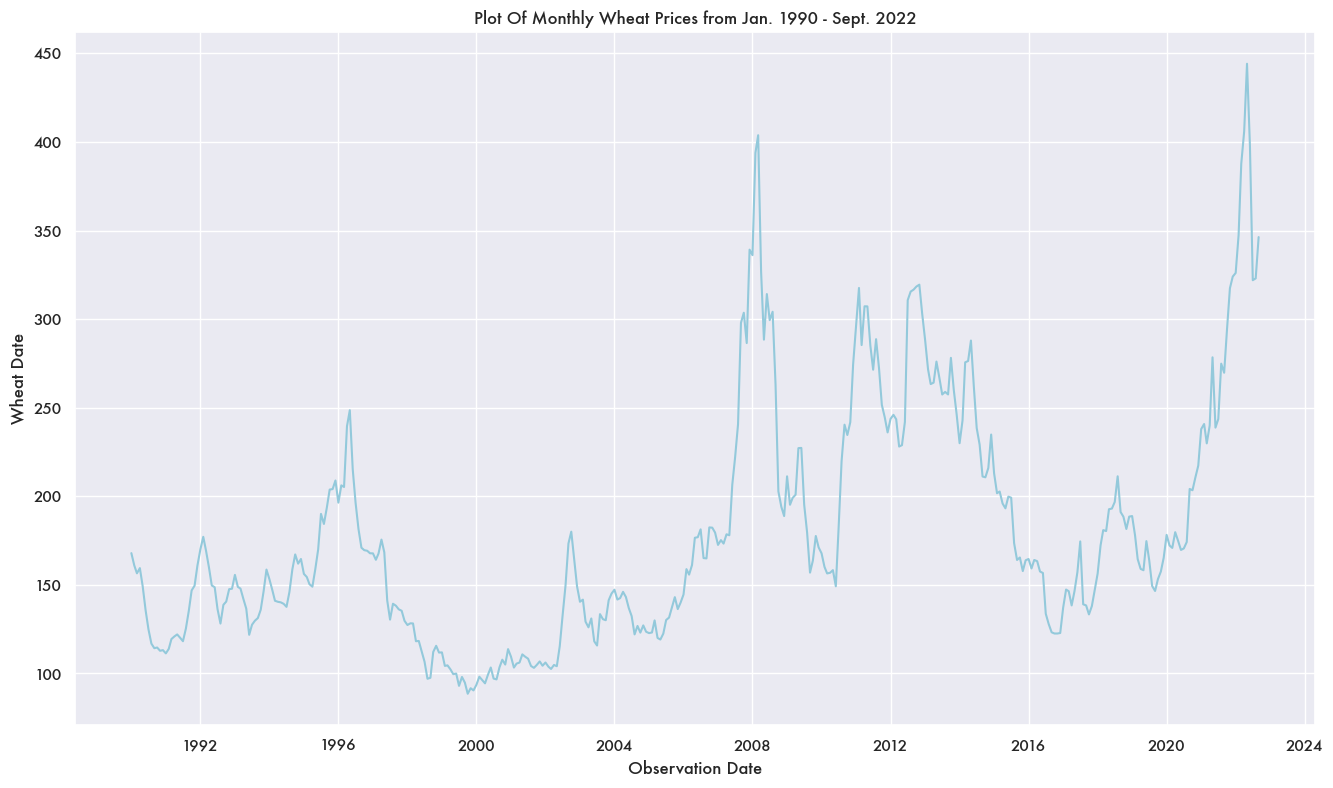

In [4]:
sns.set(rc={'figure.facecolor':'white', 'figure.figsize':(16,9)})
#sns.set_palette("ocean_r") #rocket, gist_heat_r, ocean_r, viridis_r
#splot = sns.lineplot(data=df, ci=None, x='Months', y='Mean Dist', hue='Routing Strat',style='Routing Strat', markers=['v','p', 'o', 's']) #

sns.set_theme(style='darkgrid', font = 'Futura', palette='ocean_r')
splot = sns.lineplot(data = df_wheat, x = 'observation_date', y = 'Wheat_Price')
splot.set_xlabel('Observation Date')
splot.set_ylabel('Wheat Date')
splot.set_title('Plot Of Monthly Wheat Prices from Jan. 1990 - Sept. 2022')

## Seasonality
Check for seasonality in our data, by plotting ACF of seasonal component. Seasonality is observed at lag n.

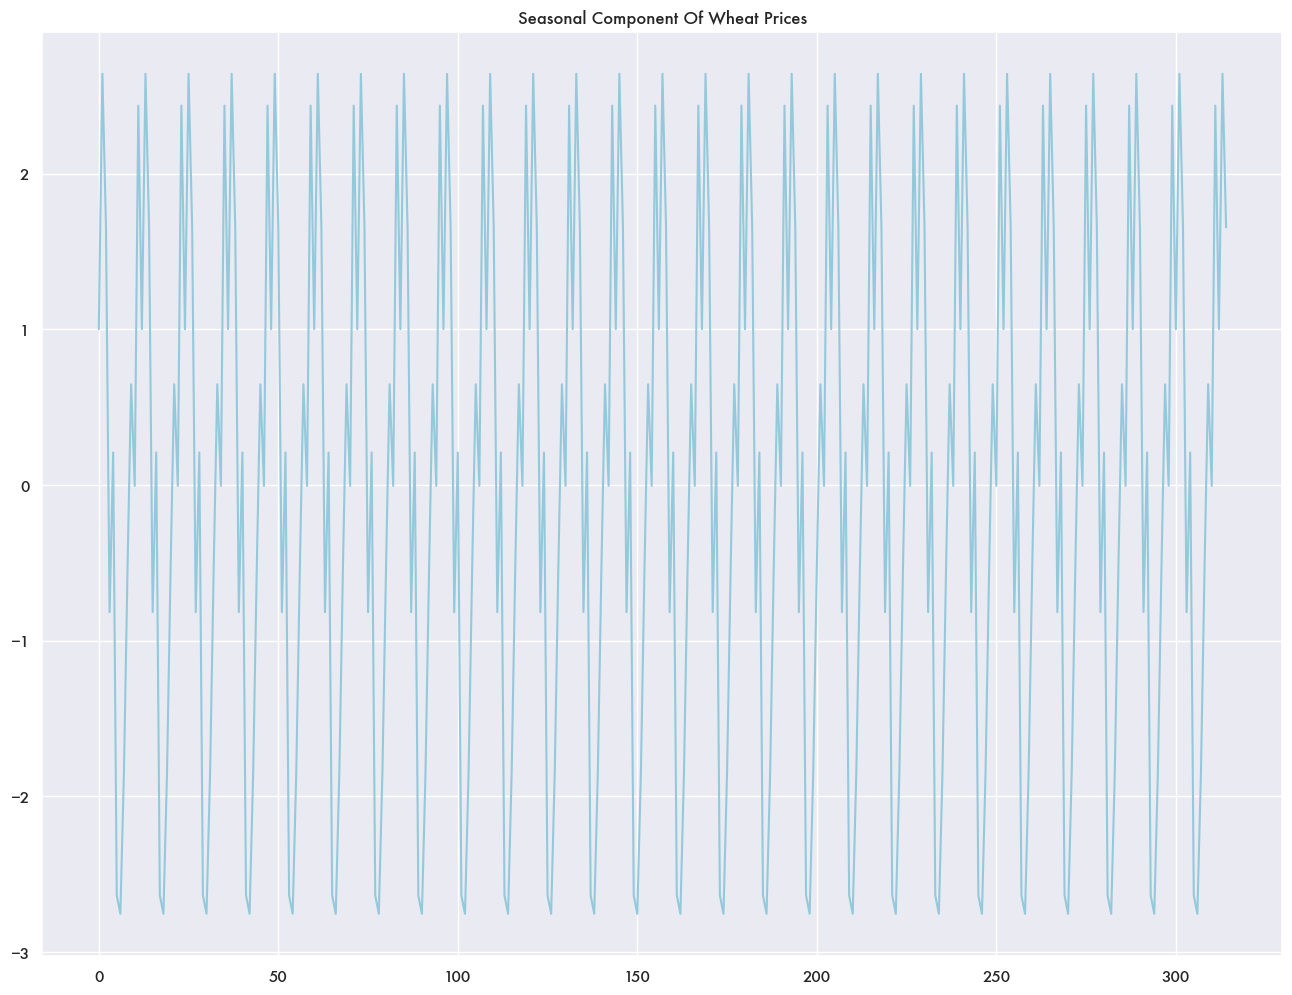

In [5]:
decomp_results = seasonal_decompose(df_wheat_train['Wheat_Price'], period=12)

# Plot decomposed data
plt.rcParams["figure.figsize"] = (16,12)
decomp_results.seasonal.plot()
plt.title('Seasonal Component Of Wheat Prices')
plt.show()

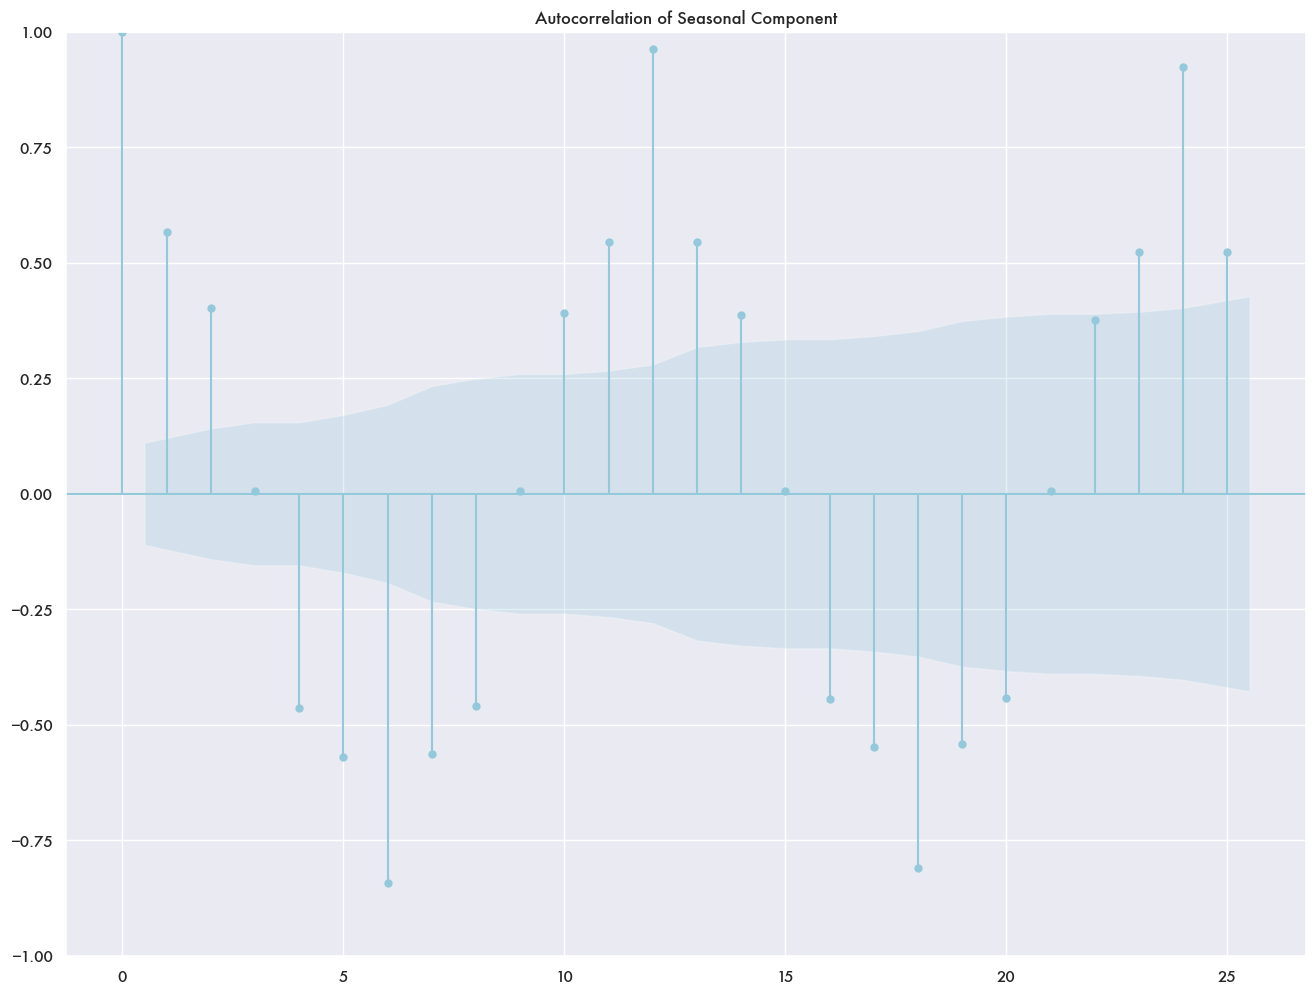

In [6]:
seasonal_acf = plot_acf(decomp_results.seasonal, title='Autocorrelation of Seasonal Component')

## Stationarity Tests
The p-value determines the result of the test. If it is smaller than a critical threshold of 0.05 or 0.01, we reject the null hypothesis and conclude that the series is stationary. Otherwise, we fail to reject the null and conclude the series is non-stationary.

In [7]:

def checkStationarity(series, critical_value):
    test_results = adfuller(series)
    if test_results[1] > critical_value:
        print('Series is Non Stationary')
    else:
        print('Series is Stationary')

    print(f"ADF test statistic: {test_results[0]}")
    print(f"p-value: {test_results[1]}")
    print("Critical thresholds:")   
    for key, value in test_results[4].items():
        print(f"\t{key}: {value}")

checkStationarity(df_wheat_train['Wheat_Price'], 0.05)

Series is Non Stationary
ADF test statistic: -2.2708845462916374
p-value: 0.18153026436022163
Critical thresholds:
	1%: -3.4519023023726696
	5%: -2.8710320399170537
	10%: -2.57182745012602


In [8]:
checkStationarity(df_wheat_train['Wheat_Price'].diff().dropna(), 0.05)

Series is Stationary
ADF test statistic: -6.933361232655497
p-value: 1.069969091583097e-09
Critical thresholds:
	1%: -3.4519023023726696
	5%: -2.8710320399170537
	10%: -2.57182745012602


In [9]:
transformed_df = pd.Series(np.log(df_wheat["Wheat_Price"])).diff().dropna()

checkStationarity(transformed_df, 0.05)

Series is Stationary
ADF test statistic: -15.727063808321123
p-value: 1.3029254061006328e-28
Critical thresholds:
	1%: -3.4471856790801514
	5%: -2.868960436182993
	10%: -2.5707229006220524


In [10]:
checkStationarity(decomp_results.seasonal, 0.05)

Series is Stationary
ADF test statistic: -4323632009620211.0
p-value: 0.0
Critical thresholds:
	1%: -3.452263435801039
	5%: -2.871190526189069
	10%: -2.571911967527952


Text(0.5, 0, 'Observation Number')

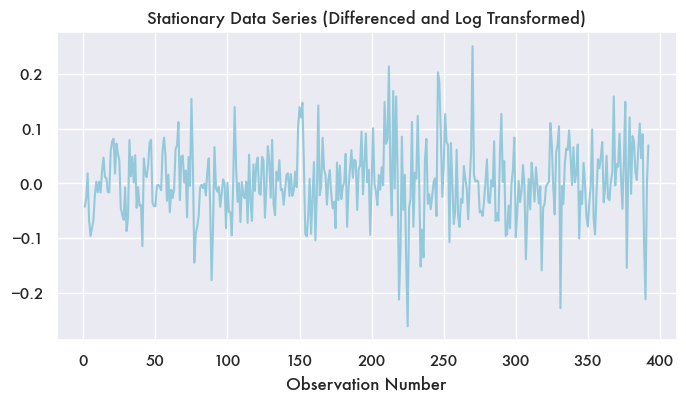

In [11]:
sns.set(rc={'figure.facecolor':'white', 'figure.figsize':(8,4)})
#sns.set_palette("ocean_r") #rocket, gist_heat_r, ocean_r, viridis_r
#splot = sns.lineplot(data=df, ci=None, x='Months', y='Mean Dist', hue='Routing Strat',style='Routing Strat', markers=['v','p', 'o', 's']) #

sns.set_theme(style='darkgrid', font = 'Futura', palette='ocean_r')
splot = sns.lineplot(data = transformed_df, x = transformed_df.index, y = transformed_df.values)
splot.set_title('Stationary Data Series (Differenced and Log Transformed)')
splot.set_xlabel('Observation Number')

/opt/homebrew/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


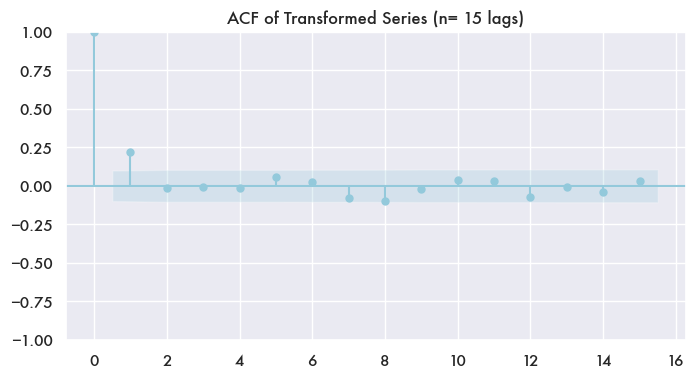

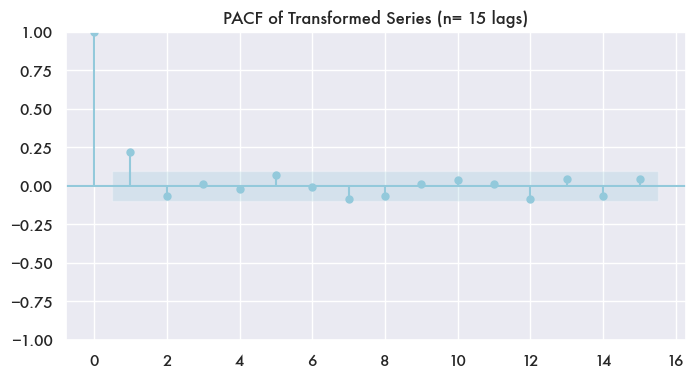

In [12]:
acf = plot_acf(transformed_df, lags = 15, title='ACF of Transformed Series (n= 15 lags)')

pacf = plot_pacf(transformed_df, lags = 15, title='PACF of Transformed Series (n= 15 lags)')

ACF at Lag 1, PACF at lag 1
AR(1), and MA(1) maybe?

In [13]:
df_wheat_train_c = df_wheat_train.copy()
df_wheat_train_c.set_index('observation_date')
model_final = SARIMAX(df_wheat["Wheat_Price"], order=(1, 1, 2), seasonal_order=(1, 0, 1, 12)).fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.08663D+00    |proj g|=  1.27395D-02

At iterate    5    f=  4.08605D+00    |proj g|=  9.17578D-03

At iterate   10    f=  4.08102D+00    |proj g|=  1.35790D-02

At iterate   15    f=  4.08063D+00    |proj g|=  6.44802D-03

At iterate   20    f=  4.08051D+00    |proj g|=  1.49228D-04

At iterate   25    f=  4.08042D+00    |proj g|=  4.70116D-03

At iterate   30    f=  4.07949D+00    |proj g|=  9.50694D-03

At iterate   35    f=  4.07668D+00    |proj g|=  3.27161D-03

At iterate   40    f=  4.07612D+00    |proj g|=  2.80990D-03

At iterate   45    f=  4.07573D+00    |proj g|=  2.83396D-03

At iterate   50    f=  4.07564D+00    |proj g|=  5.19823D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [71]:
from pmdarima import auto_arima
auto_arima(df_wheat["Wheat_Price"],  m = 12, Trace = True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  393
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1603.716
Date:                            Fri, 30 Dec 2022   AIC                           3217.431
Time:                                    14:45:37   BIC                           3237.287
Sample:                                         0   HQIC                          3225.301
                                            - 393                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3610      0.118     -3.067      0.002      -0.592      -0.130
ma.L1          0.5956      0.096      6.215      0.000       0.408       0.783
ar.S.L12       0.6547      0.226      2.902      0.004       0.212       1.097
ma.S.L12      -0.7589      0.202     -3.759      0.000      -1.155      -0.363
sigma2       209.0846      8.134     25.705      0.000     193.142     225.027
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               470.75
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               3.98   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
auto_arima(df_wheat['Wheat_Price'], m = 12, d =1, max_d=7,trace=True, error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3239.758, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3226.318, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3222.059, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3238.118, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3221.549, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3222.302, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3220.318, Time=0.58 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=3223.050, Time=1.17 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=3222.737, Time=1.36 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3221.021, Time=0.91 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=3221.735, Time=0.58 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=2.15 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3238.515, Time=0.59 sec
 ARIMA(1,1,1)(1,0,1)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  393
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1603.716
Date:                            Fri, 30 Dec 2022   AIC                           3217.431
Time:                                    14:48:46   BIC                           3237.287
Sample:                                         0   HQIC                          3225.301
                                            - 393                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3610      0.118     -3.067      0.002      -0.592      -0.130
ma.L1          0.5956      0.096      6.215      0.000       0.408       0.783
ar.S.L12       0.6547      0.226      2.902      0.004       0.212       1.097
ma.S.L12      -0.7589      0.202     -3.759      0.000      -1.155      -0.363
sigma2       209.0846      8.134     25.705      0.000     193.142     225.027
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               470.75
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               3.98   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
model_auto = SARIMAX(df_wheat["Wheat_Price"], order=(1, 1, 2), seasonal_order=(1, 1, 2, 12)).fit()


/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.12430D+00    |proj g|=  1.11742D-01


 This problem is unconstrained.



At iterate    5    f=  4.09308D+00    |proj g|=  7.80123D-02

At iterate   10    f=  4.02174D+00    |proj g|=  1.78139D-02

At iterate   15    f=  4.01824D+00    |proj g|=  8.10544D-04

At iterate   20    f=  4.01794D+00    |proj g|=  5.05833D-03

At iterate   25    f=  4.01768D+00    |proj g|=  1.60648D-03

At iterate   30    f=  4.01764D+00    |proj g|=  3.63806D-04

At iterate   35    f=  4.01763D+00    |proj g|=  5.61714D-04

At iterate   40    f=  4.01761D+00    |proj g|=  9.55678D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     71      2     0     0   6.258D-06   4.018D+00
  F =   4.0176047212024200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [75]:
model_auto_2 = SARIMAX(df_wheat["Wheat_Price"], order=(1, 1, 1), seasonal_order=(1, 0, 1, 12)).fit()
model_auto_2.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.08711D+00    |proj g|=  1.27562D-02

At iterate    5    f=  4.08535D+00    |proj g|=  1.62431D-02


 This problem is unconstrained.



At iterate   10    f=  4.08280D+00    |proj g|=  2.06024D-02

At iterate   15    f=  4.08081D+00    |proj g|=  3.13714D-03

At iterate   20    f=  4.08070D+00    |proj g|=  4.66208D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   1.137D-05   4.081D+00
  F =   4.0807010273022462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Wheat_Price   No. Observations:                  393
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1603.716
Date:                            Fri, 30 Dec 2022   AIC                           3217.431
Time:                                    14:49:28   BIC                           3237.287
Sample:                                         0   HQIC                          3225.301
                                            - 393                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3610      0.118     -3.067      0.002      -0.592      -0.130
ma.L1          0.5956      0.096      6.215      0.000       0.408       0.783
ar.S.L12       0.6547      0.226      2.902      0.004       0.212       1.097
ma.S.L12      -0.7589      0.202     -3.759      0.000      -1.155      -0.363
sigma2       209.0846      8.134     25.705      0.000     193.142     225.027
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               470.75
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               3.98   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
df_wheat_train.tail()

,observation_date,Wheat_Price
310,2015-11-01,157.804379
311,2015-12-01,163.893455
312,2016-01-01,164.611627
313,2016-02-01,159.283795
314,2016-03-01,164.060472


In [18]:
df_wheat_co = df_wheat.copy()
df_wheat_co.set_index('observation_date', inplace=True)
df_wheat_co

,Wheat_Price
observation_date,
1990-01-01,167.918579
1990-02-01,160.937271
1990-03-01,156.528030
1990-04-01,159.467529
1990-05-01,149.179291
...,...
2022-05-01,444.156568
2022-06-01,397.652320
2022-07-01,321.975128


In [80]:
model_auto_2 = SARIMAX(df_wheat_co["Wheat_Price"], order=(2, 1, 2), seasonal_order=(1, 1, 2, 12)).fit()
#model_auto_2 = SARIMAX(df_wheat_co["Wheat_Price"], order=(1, 1, 1), seasonal_order=(1, 0, 1, 12)).fit()


/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.12414D+00    |proj g|=  1.11829D-01


 This problem is unconstrained.



At iterate    5    f=  4.08716D+00    |proj g|=  8.24688D-02

At iterate   10    f=  4.02178D+00    |proj g|=  8.55807D-03

At iterate   15    f=  4.01772D+00    |proj g|=  6.65028D-04

At iterate   20    f=  4.01769D+00    |proj g|=  3.09567D-03

At iterate   25    f=  4.01756D+00    |proj g|=  2.12811D-03

At iterate   30    f=  4.01752D+00    |proj g|=  8.98186D-04

At iterate   35    f=  4.01748D+00    |proj g|=  2.33886D-03

At iterate   40    f=  4.01661D+00    |proj g|=  3.66186D-03

At iterate   45    f=  4.01613D+00    |proj g|=  3.11517D-03


/opt/homebrew/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.01531D+00    |proj g|=  3.52797D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   3.528D-03   4.015D+00
  F =   4.0153121892321879     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


Text(0.5, 0, 'Years')

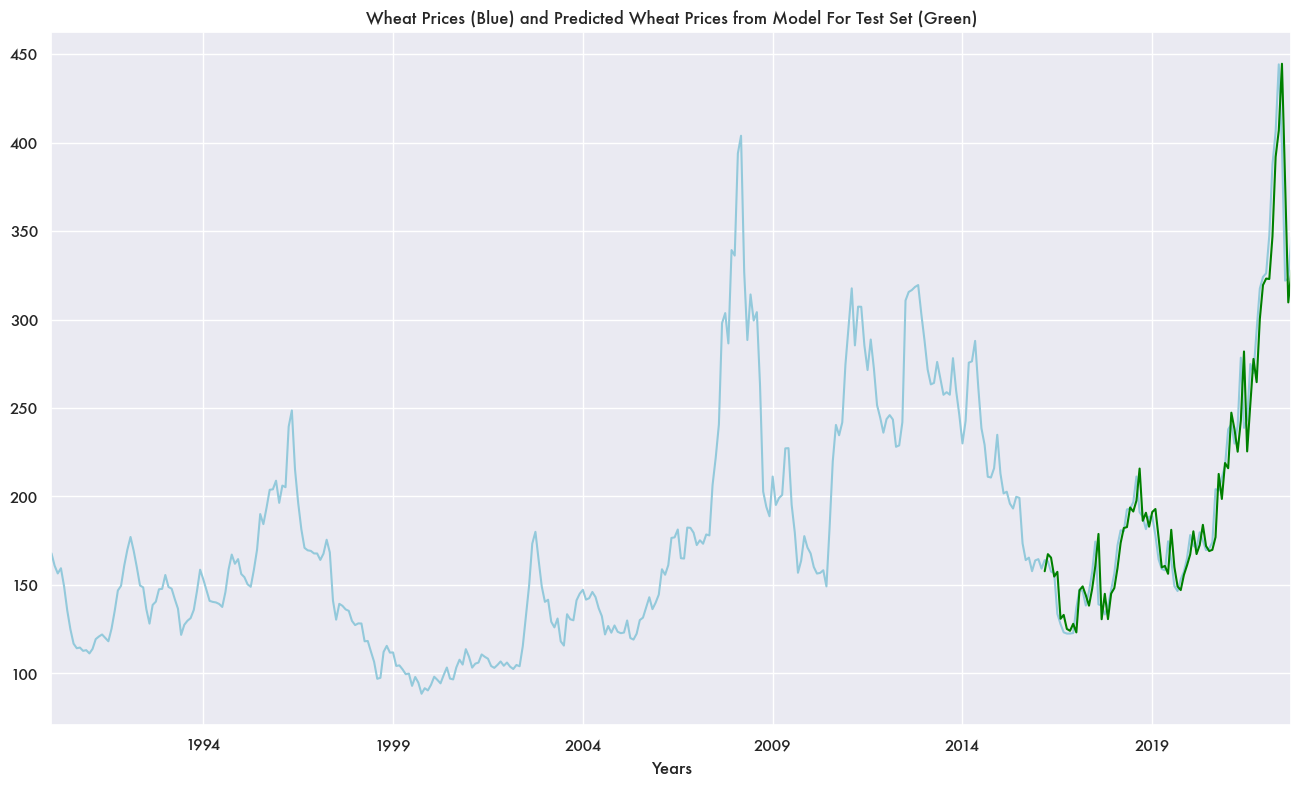

In [20]:
pred = model_auto_2.predict(start = 314, end = 392)
ax = df_wheat_co['Wheat_Price'].plot(figsize=(16, 9))
pred.plot(ax = ax, color = 'green')
ax.set_title('Wheat Prices (Blue) and Predicted Wheat Prices from Model For Test Set (Green)')
ax.set_xlabel('Years')

Text(630, 150, 'Forecasted Values CI')

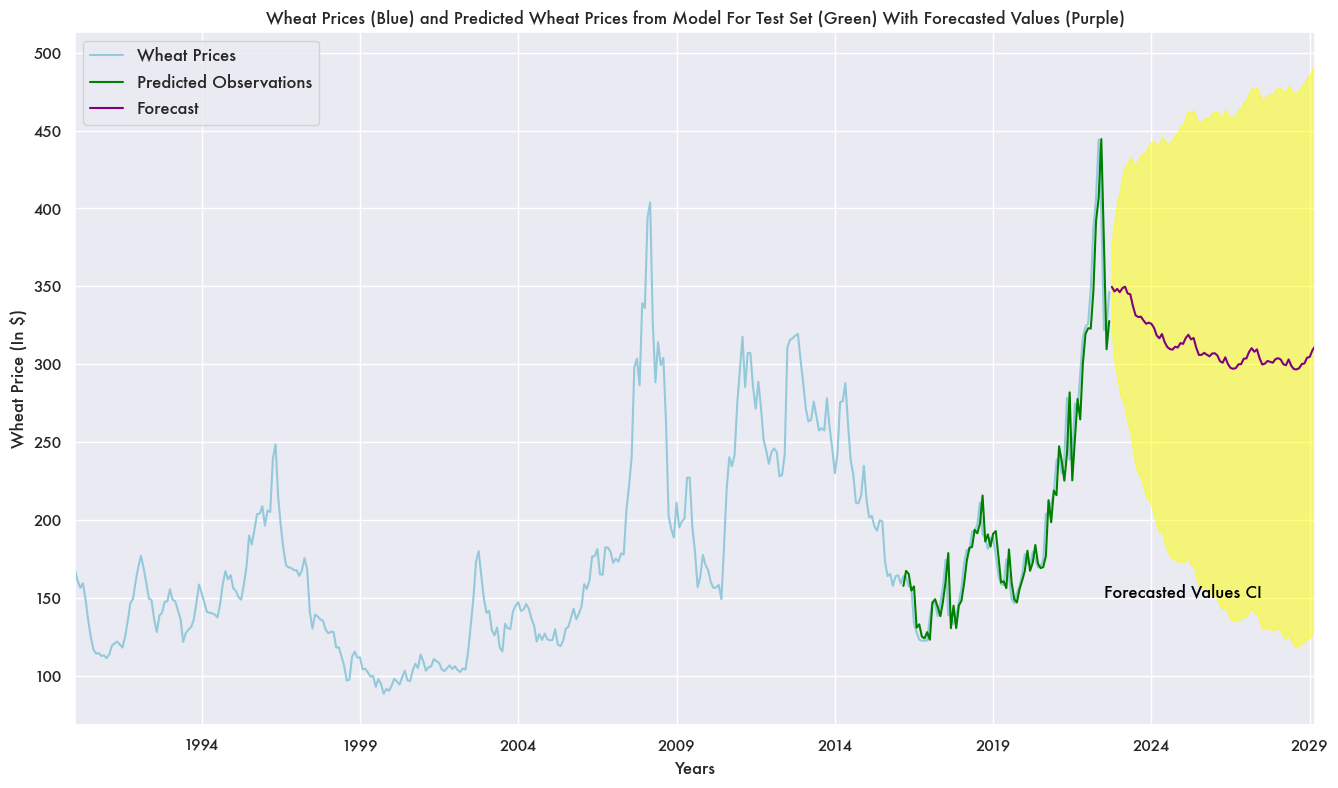

In [81]:
forecast_values = model_auto_2.get_forecast(steps=(392-314))
forecast_ci = forecast_values.conf_int()
ax = df_wheat_co['Wheat_Price'].plot(figsize=(16, 9), label = 'Wheat Prices')
pred.plot(ax = ax, color = 'green', label = 'Predicted Observations')
ax.set_title('Wheat Prices (Blue) and Predicted Wheat Prices from Model For Test Set (Green) With Forecasted Values (Purple)')
ax.set_xlabel('Years')
ax.set_ylabel('Wheat Price (In $)')
forecast_values.predicted_mean.plot(ax=ax, label='Forecast', grid=True, color = 'purple')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='yellow', alpha = .5)
plt.legend(loc='upper left', prop={'size': 12})
ax.text(630, 150, 'Forecasted Values CI', fontsize=12,  color='black')

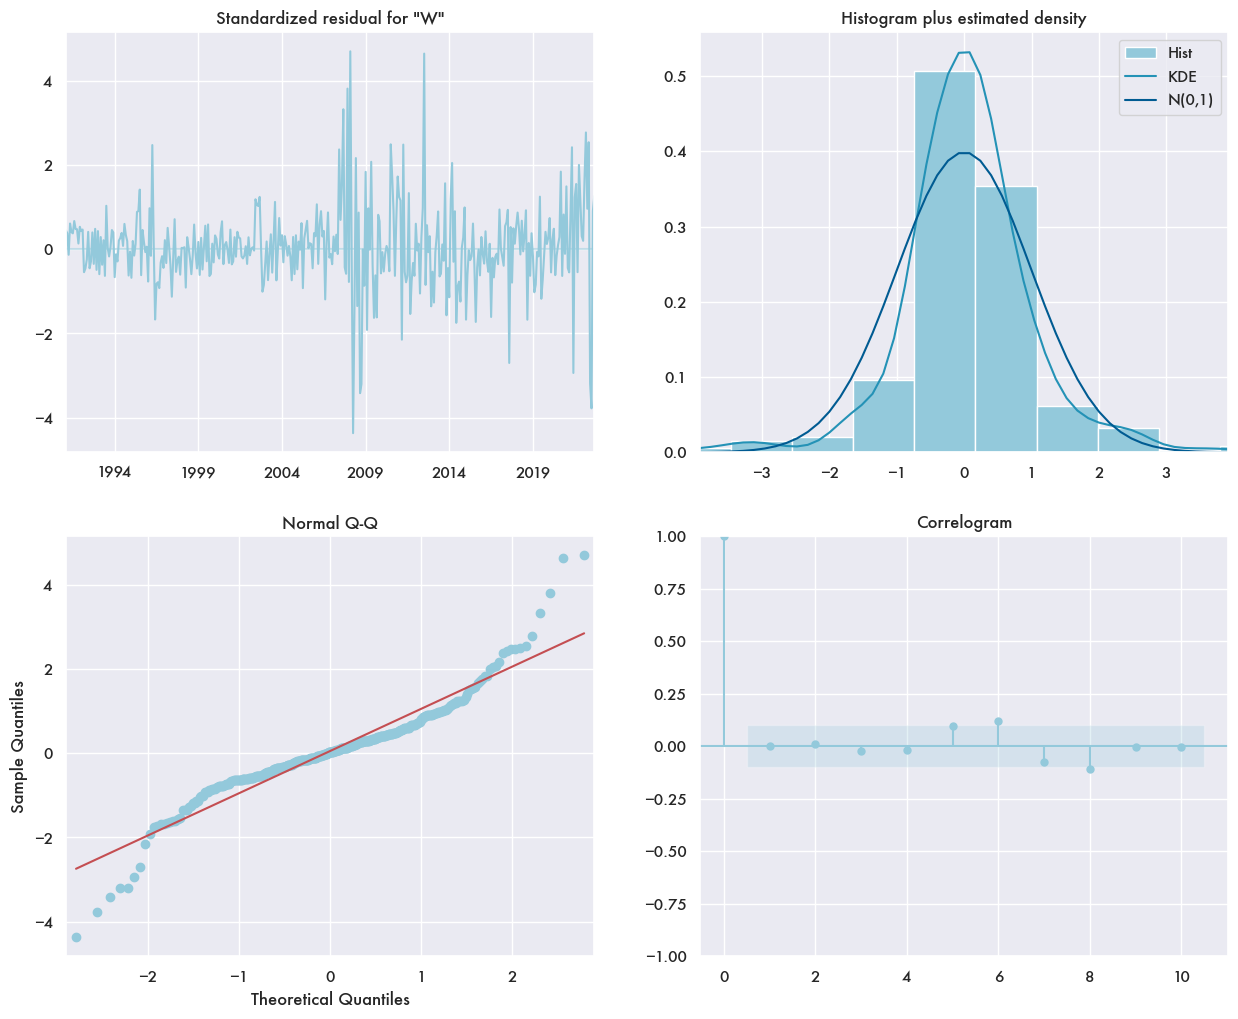

In [63]:
diagnostics = model_auto_2.plot_diagnostics(figsize=(15,12))

In [22]:
predict = model_auto_2.predict(start = 0, end = 392)


In [23]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predict.values, df_wheat['Wheat_Price'])
error

17.608774913221847